In [1]:
%cd /kaggle/working

import os

from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../experiments/016_norm_v5"):
    cfg = compose(
        config_name="config.yaml", overrides=["debug=True"], return_hydra_config=True
    )

/kaggle/working


In [2]:
DT = 1800.0
L_V = 2.501e6  # Latent heat of vaporization
L_I = 3.337e5  # Latent heat of freezing
L_F = L_I
L_S = L_V + L_I  # Sublimation
C_P = 1.00464e3  # Specific heat capacity of air at constant pressure
G = 9.80616
P0 = 1e5
RHO_L = 1e3

In [3]:
import plotly.express as px
import polars as pl

df = pl.read_parquet("input/train.parquet", n_rows=100000)

In [4]:
import xarray as xr

grid_path = "/kaggle/working/misc/grid_info/ClimSim_low-res_grid-info.nc"
grid_info = xr.open_dataset(grid_path)
grid_info

<xarray.Dataset> Size: 14kB
Dimensions:  (time: 1, ncol: 384, ilev: 61, lev: 60)
Coordinates:
  * ilev     (ilev) float64 488B 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * lev      (lev) float64 480B 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
Dimensions without coordinates: time, ncol
Data variables:
    P0       float64 8B ...
    PS       (time, ncol) float32 2kB ...
    area     (ncol) float64 3kB ...
    hyai     (ilev) float64 488B ...
    hyam     (lev) float64 480B ...
    hybi     (ilev) float64 488B ...
    hybm     (lev) float64 480B ...
    lat      (ncol) float64 3kB ...
    lon      (ncol) float64 3kB ...
Attributes: (12/19)
    ne:                4
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ea...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  month_1

In [7]:
df[:, 1:].columns.index("state_ps")

360

## dP

In [112]:
# am,bm
hyam = grid_info["hyam"].to_numpy()
hybm = grid_info["hybm"].to_numpy()
p0 = 1e5
ps = df["state_ps"].to_numpy()
pressures = hyam * p0 + hybm[None, :] * ps[:, None]
pressures.shape, pressures

((100000, 60),
 array([[7.83478113e+00, 1.41108318e+01, 2.52923297e+01, ...,
         9.74450233e+04, 9.89064246e+04, 1.00388943e+05],
        [7.83478113e+00, 1.41108318e+01, 2.52923297e+01, ...,
         9.77239937e+04, 9.91905416e+04, 1.00678281e+05],
        [7.83478113e+00, 1.41108318e+01, 2.52923297e+01, ...,
         9.54708095e+04, 9.68957892e+04, 9.83413596e+04],
        ...,
        [7.83478113e+00, 1.41108318e+01, 2.52923297e+01, ...,
         9.76039582e+04, 9.90682916e+04, 1.00553784e+05],
        [7.83478113e+00, 1.41108318e+01, 2.52923297e+01, ...,
         9.75687549e+04, 9.90324389e+04, 1.00517273e+05],
        [7.83478113e+00, 1.41108318e+01, 2.52923297e+01, ...,
         9.76601214e+04, 9.91254910e+04, 1.00612035e+05]]))

In [113]:
# ai, bi
hyai = grid_info["hyai"].to_numpy()
hybi = grid_info["hybi"].to_numpy()
p0 = 1e5
ps = df["state_ps"].to_numpy()
pressures_v2 = hyai * p0 + hybi[None, :] * ps[:, None]
pressures_v2 = np.diff(pressures_v2, n=1)
pressures_v2.shape, pressures_v2

((100000, 60),
 array([[   4.49334817,    8.05875326,   14.30424243, ..., 1451.11266244,
         1471.68984952, 1493.34682294],
        [   4.49334817,    8.05875326,   14.30424243, ..., 1456.22305609,
         1476.87270999, 1498.60595293],
        [   4.49334817,    8.05875326,   14.30424243, ..., 1414.94749233,
         1435.01184709, 1456.12907736],
        ...,
        [   4.49334817,    8.05875326,   14.30424243, ..., 1454.02415392,
         1474.64262677, 1496.34305243],
        [   4.49334817,    8.05875326,   14.30424243, ..., 1453.37927317,
         1473.98860143, 1495.67940264],
        [   4.49334817,    8.05875326,   14.30424243, ..., 1455.05299526,
         1475.68605737, 1497.40183786]]))

In [114]:
t_cols = [f"ptend_t_{i}" for i in range(60)]
t_array = df[t_cols][0].to_numpy()

q0001_cols = [f"ptend_q0001_{i}" for i in range(60)]
q0001_array = df[q0001_cols][0].to_numpy()

q0002_cols = [f"ptend_q0002_{i}" for i in range(60)]
q0002_array = df[q0002_cols][0].to_numpy()

q0003_cols = [f"ptend_q0003_{i}" for i in range(60)]
q0003_array = df[q0003_cols][0].to_numpy()

In [115]:
t = (t_array * pressures_v2).sum(axis=1) * C_P / G
t[:10]

array([-202.98457083, -203.65381852, -198.24844712, -202.18452895,
       -203.19974194, -202.87435167, -202.82556951, -203.37534431,
       -202.36159761, -200.43451654])

In [116]:
sq0001_cols = [f"state_q0001_{i}" for i in range(60)]
sq0001_array = df[sq0001_cols][0].to_numpy()

sq0002_cols = [f"state_q0002_{i}" for i in range(60)]
sq0002_array = df[sq0002_cols][0].to_numpy()

sq0003_cols = [f"state_q0003_{i}" for i in range(60)]
sq0003_array = df[sq0003_cols][0].to_numpy()

In [117]:
water_array = (
    df[q0001_cols].to_numpy() + df[q0002_cols].to_numpy() + df[q0003_cols].to_numpy()
)
total_water_errr = (water_array * pressures_v2 / G).sum(axis=1)
total_water_errr[:10]

array([ 6.29182031e-07, -2.58264583e-06,  2.59379624e-06, -2.43335887e-05,
       -2.91340828e-08, -1.29465991e-05, -1.09074563e-04, -1.58787304e-04,
       -5.33405888e-05,  1.65656542e-13])

In [118]:
water_array = (
    df[sq0001_cols].to_numpy() + df[sq0002_cols].to_numpy() + df[sq0003_cols].to_numpy()
)
total_water = (water_array * pressures_v2 / G).sum(axis=1)
total_water[:10]

array([24.85765022, 19.67242225, 38.58525545, 37.84883581, 19.80491455,
       29.19747821, 49.52172499, 50.87751134, 37.27527963, 34.66226362])

In [119]:
surface_water_flux = -1e3 * (
    df[["cam_out_PRECC"]].to_numpy().flatten()
)  # convert from m/s to kg/m2/s with factor of 1000; positive values into atmosphere

surface_water_flux[:10]

array([-2.94767248e-09, -3.13836586e-06, -7.42421523e-06, -2.53409014e-05,
       -3.37741547e-07, -1.87480286e-05, -8.45100286e-05, -1.64397332e-04,
       -4.25005947e-05, -0.00000000e+00])

In [120]:
(total_water_errr - surface_water_flux)[:10]

array([ 6.32129703e-07,  5.55720028e-07,  1.00180115e-05,  1.00731266e-06,
        3.08607465e-07,  5.80142949e-06, -2.45645348e-05,  5.61002762e-06,
       -1.08399941e-05,  1.65656542e-13])

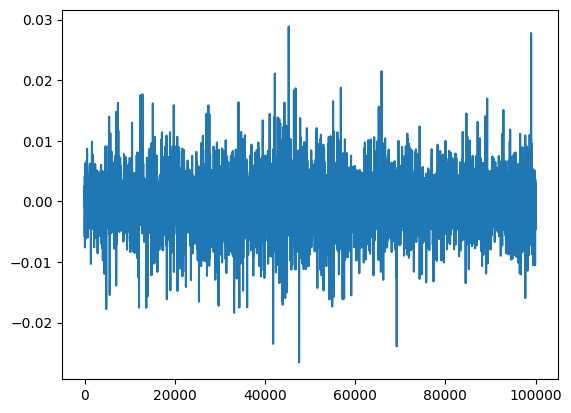

In [128]:
import matplotlib.pyplot as plt
import numpy as np

# 折れ線グラフを出力
left = np.arange(100000)
plt.plot(left, 1200 * (total_water_errr - surface_water_flux) / total_water)

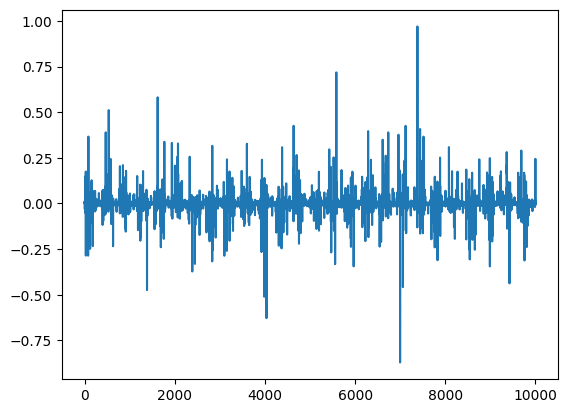

In [135]:
# 折れ線グラフを出力
left = np.arange(10000)
plt.plot(left, (1200 * (total_water_errr - surface_water_flux))[:10000])

In [126]:
change_rate = 1200 * (total_water_errr - surface_water_flux) / total_water
import pandas as pd

pd.DataFrame(pd.Series(change_rate.ravel()).describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
0,100000.0,0.000003,0.001213,-0.026569,-0.000063,-2.366801e-16,0.000084,0.028851


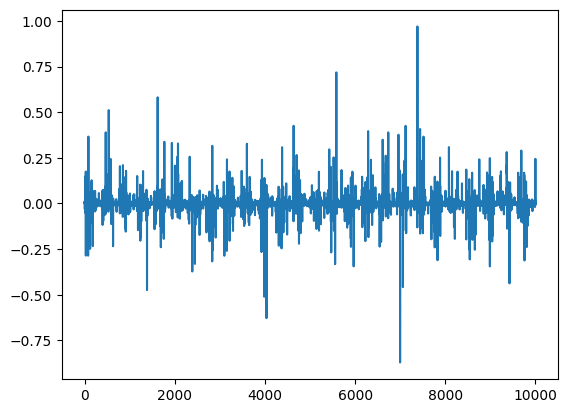

In [148]:
# 折れ線グラフを出力
left = np.arange(10000)
plt.plot(
    left,
    (1200 * (total_water_errr - surface_water_flux))[:10000],
)

In [142]:
df[:, 1:].columns.index("state_ps")

360

In [143]:
df[:, 1:].columns.index("cam_out_PRECC") - 557

362

pbuf_LHFLX
f64
0.000036
0.000041
0.000075
0.000101
0.000027
…
0.000064
0.000056
0.000036


In [12]:
C_P * t_array.sum()

-1.479145326211788

In [26]:
q0001_array.sum()

-3.320673868834854e-08

In [27]:
q0002_array.sum()

-1.110027167237154e-08

In [28]:
q0003_array.sum()

-2.1122588405150454e-09

array([[89.48877446]])

In [31]:
df[["cam_out_PRECC"]][0].to_numpy(), df[["cam_out_PRECSC"]][0].to_numpy()

(array([[2.94767248e-12]]), array([[0.]]))

In [36]:
(df["state_ps"][0] - P0) / 60 * G / L_V

7.421055217492985e-05